<img src="https://drive.google.com/uc?id=1DvKhAzLtk-Hilu7Le73WAOz2EBR5d41G" width="500"/>


---


# **Diffusion models**

#### **Morning contents/agenda**

1. *Why* use diffusion models?

2. *What* are diffusion models?

3. *How* do they work? ([DDPM](https://arxiv.org/abs/2006.11239) implementation)

#### **Afternoon contents/agenda**

1. Exercises

2. Stable diffusion

<br/>

---

Author: George Strong

gs914@ic.ac.uk

<br/>

# 1. *Why* use diffusion models?

#### **Concept and motivation**

Many generative modelling techniques, such as [variational autoencoders](https://arxiv.org/abs/1312.6114) (VAEs) and [generative adversarial networks](https://arxiv.org/abs/1406.2661) (GANs), attempt to go directly from a random latent-space sample to a generated output in one forward pass of a network. This is a *very* difficult thing to do for an artificial neural network. It is also a *very* difficult and unnatural thing for a biological neural network to do. For instance, when an author writes a novel, or an artist creates a painting, they do so by gradually refining it over many iterations. Rarely will an author or artist produce their final creation with one train of thought! This observation is the core inspiration behind diffusion models, a (relatively) new type of deep generative model.

<br/>

Many of the important limitations of VAEs and GANs can be considered a consequence of the aforementioned difficulty in generating data samples with a single network evaluation. VAEs optimise a surrogate loss that is only an *approximation* of maximum likelihood training. This has practical negative consequences on the quality of the generated outputs. Meanwhile, the adversarial training scheme used to optimise GANs is [notoriously unstable](https://arxiv.org/abs/1606.03498). It is also often unfaithful to the true data distribution ([mode collapse](https://arxiv.org/abs/1611.02163)). In truth, the generator doesn't (directly) care about learning a representative model of the data distribution, so long is it can fool the discriminator.

<br/>

Diffusion models have the potential to circumvent these issues. They benefit from a stable training scheme, and can generate very high quality samples that are competitive with (and now often surpass) those produced using GANs. This is not to say diffusion models are a perfect silver bullet solution, and they certainly have important limitations of there own.

<br/>

*“All models are wrong, but some are useful”* - George E. P. Box.

<br/>

A single pass through a diffusion model will likely produce samples that are *“wrong”* and typically much worse than that produced by a VAE or GAN. However, diffusion models are designed to be *“useful”* over many hundreds or thousands of iterations (and network evaluations). A negative consequence of this is that using diffusion models for inference is considerably more computationally expensive than a VAE or GAN, which only require a single pass through the network.

<br>

#### **The results speak for themselves**

**Imagen**

Developed by Google Research, Brain Team. See paper [here](https://arxiv.org/abs/2205.11487).

In [1]:
from IPython import display
display.IFrame('https://imagen.research.google/', width=1000, height=600)

**DALL$\cdot$E 2**

Developed by OpenAI. See paper [here](https://cdn.openai.com/papers/dall-e-2.pdf).

In [2]:
display.IFrame('https://dreamstudio.ai/', width=1000, height=600)

**Video Diffusion Models**

Developed by Ho et al. 2022. See paper [here](https://arxiv.org/abs/2204.03458).

In [3]:
display.IFrame('https://video-diffusion.github.io/', width=1000, height=600)



---



# 2. *What* are diffusion models?

#### **Energy-based models**

An unconditional energy-based model $E_{\theta}$ over a single independent variable $\mathbf{x}$ is a model with parameters $\theta$, that takes a sample $\mathbf{x}$ and predicts a scalar value $E_{\theta}(\mathbf{x})$ termed the energy. If the sample $\mathbf{x}$ is "good" then $E_{\theta}(\mathbf{x})$ will be a small number, and vice versa. $E_{\theta}$ can be parameterised by any desired regression function (e.g. a deep neural network), and it can be transformed into a probability density function using the Boltzmann distribution:

<br>

$p_{\theta}(\mathbf{x}) = \text{exp}(-E_{\theta}(\mathbf{x}))/Z$

<br>

where $Z$ represents the typically intractable partition function $Z = \int_{-\infty}^{\infty}\text{exp}(-E_{\theta}(\mathbf{x}))\ \text{d}\mathbf{x}$. From this equation, we can see that $E_{\theta}$ can be interpreted as an unnormalized negative log-probability $-\text{log}p(\mathbf{x})$.

<br>

If we can train the energy-based model $E_{\theta}$ to provide a well behaved energy landscape, then we will be able to use its gradient $\nabla_{x}E_{\theta}(\mathbf{x})$ to navigate towards low-energy, "good" quality samples. Although EBMs are flexible, they are notoriously difficult to train! [Here](https://arxiv.org/abs/2101.03288) is a helpful article if you are curious about energy-based models and how to train them.

<br>

#### **Origin**

The rise of diffusion models began in 2019, with the [paper](https://arxiv.org/abs/1907.05600) titled "Generative Modeling by Estimating Gradients of the Data Distribution" by Yang Song and Stefano Ermon.

<br>

Rather than predicting the log-probability of the data $\text{log}p(\mathbf{x})$ (or $-E_{\theta}(\mathbf{x})$), they train a network to predict the gradients of the log-data distribution $\nabla_{\mathbf{x}}\text{log}p(\mathbf{x})$, also known as the score function. These predicted gradients can then be used for gradient-based sampling (e.g. Langevin dynamics) to steer $\mathbf{x}$ towards higher-density regions and generate accurate samples from the data distribution.

<br>

#### **Langevin dynamics**

[Langevin dynamics](https://en.wikipedia.org/wiki/Langevin_dynamics) is an iterative sampling method that iteratively updates the sample $\mathbf{x}_{t}$ according to some desired gradient term, in our case the gradient of the log-data distribution $\nabla_{\mathbf{x}_{t}}\text{log}p(\mathbf{x}_{t})$, plus a small amount of Gaussian noise $\mathbf{z}_{t}$. The Langevin update equation for drawing samples from the data distribution is defined as:

$\mathbf{x}_{t+1} \leftarrow \mathbf{x}_{t}+\alpha \nabla_{\mathbf{x_{t}}}\text{log}\ p(\mathbf{x}_{t}) + \mathbf{z}_{t}$



<br>

<img src="https://yang-song.net/assets/img/score/langevin.gif" alt="network" width="300"/>

<br>


#### **Noise perturbation**

If we train a network to estimate $\nabla_{\mathbf{x}_{t}}\text{log}p(\mathbf{x}_{t})$, start with a random Gaussian sample $\mathbf{x}\sim\mathcal{N}(\mathbf{0},\mathbf{I})$, and apply Langevin dynamics, we "should" be able to generate data, right?

<br>

In practice, this doesn't work because high-dimensional data distributions are almost always concentrated in proportionally small, high-density regions. Outside of these small high-density regions, the gradients of the data distribution are very noisy and practically undefined (because there is almost no data coverage) in these vast areas of the data-space.

<br>

Another important issue is that high-dimensional data actually resides on low-dimensional latent manifolds that are embedded in high-dimensional space (see the [manifold hypothesis](https://en.wikipedia.org/wiki/Manifold_hypothesis)). If the data is restricted to a low-dimensional manifold, the gradients of the log-data distribution in the high-dimensional data-space will be undefined.

<br/>

Yang and Ermon's proposed solution is to add random noise to the data, and train a noise-conditioned network to estimate the gradient of the noise-perturbed log-data distribution. If the magnitude of the noise is large, then it is able to populate low-density regions and circumvent the manifold hypothesis, enabling accurate gradient estimates. The noise can then be gradually reduced during the sampling process to generate accurate data samples.

<br>

<img src="https://yang-song.net/assets/img/score/ald.gif" alt="network" width="600"/>

<br>

<img src="https://yang-song.net/assets/img/score/cifar10_large.gif" alt="network" width="400"/> &nbsp; &nbsp; <img src="https://yang-song.net/assets/img/score/celeba_large.gif" alt="network" width="400"/>

<br>

Generative models such as this, which comprise a network that predicts the score function $\nabla_{\mathbf{x}_{t}}$log$p(\mathbf{x}_{t})$, are collectively known as score-based generative models (SBGM). For further information on the specifics of how score-based generative models are trained and used, see Yang Song's excellent [blogpost](https://yang-song.net/blog/2021/score/) and [this](https://arxiv.org/abs/2101.03288) tutorial.

<br>

#### **Diffusion models**

SBGMs were the catalyst that inspired a multitude of different techniques that are collectively referred to as diffusion models. All of which share the common theme of learning how to gradually reverse the process of corrupting a data sample.

<br>

<img src="https://github.com/ese-msc-2023/DL_module_2023/blob/main/Day10-Diffusion_models/figures/diff.png?raw=1" width="800"/>

<br>

As we have discussed, SBGMs tackles the reverse process by learning to predict the score function conditioned at a particular time (or noise level) $t$. Langevin dynamics is then used to step through the reverse diffusion process.

<br>

Perhaps the most popular type of diffusion model is the denoising diffusion probabilistic model (DDPM). The DDPM tackles the reverse process by learning to predict the noise contained within an image at a particular time (or noise level) $t$. We can then iteratively predict and subtract this noise from our sample, effectively denoising it, from time $t=T$ to $t=0$.

<br>

<br>

---



# 3. *How* do they work?

We will answer this question and learn by doing. Our challenge today will be to implement the denoising diffusion probabilistic model directly from the [paper](https://arxiv.org/abs/2006.11239).

Let's dive in and see exactly how these models work!

## *i*. Setting up our colab environment

#### **Mounting your google drive**

In [4]:
#from google.colab import drive
#drive.mount('/content/gdrive/')

#### **Imports**

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms

#### **Using the GPU**

Google Colab enables us to obtain free GPU computing resources.  
You can switch the runtime of Google Colab from CPU to GPU based via the ```toolbar```:  

Commands:
```Runtime -> Change Runtime Type -> Hardware Accelerator -> GPU```

In [6]:
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
    !nvidia-smi
else:
    print("No GPU available!")

Cuda installed! Running on GPU!
Sun Dec 10 23:17:50 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                        

## *ii*. Load and normalize the MNIST dataset

We will be implementing and training our DDPM on the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset today. As mentioned in the DDPM paper (**section 3.3 and section 4**), the data was scaled to the range [-1,1], and so we will implement this as a transformation upon loading.

In [7]:
# define torch transformations
img_dim = 32
tf = transforms.Compose([transforms.ToTensor(), ### your code goes here # convert to a tensor and normalize to [0,1]
                         transforms.Resize((img_dim, img_dim), antialias=True), ### your code goes here # resize images to 32x32 for ease-of-use with the U-Net architecture
                         transforms.Lambda(lambda t: (t * 2) - 1) ### your code goes here # scale to the range [-1,1]
])
# download and define MNIST as a torch dataset, using the above transformations
dataset = torchvision.datasets.MNIST("./", download=True, train=True, transform=tf)

100%|██████████| 9912422/9912422 [00:00<00:00, 172584220.26it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 115367327.45it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 41395915.39it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 1037440.98it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [8]:
# define a torch dataloader with a batch size of 64
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [9]:
# grab a batch of data and pull out the first 16 images
x0 = next(iter(dataloader))[0][:16]
x0

tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        ...,


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., 

In [10]:
# define a plotting function to visualize the batch as a grid image
def plot_batch(x):
    """plot batch x as grid image"""

    # re-scale and clamp to the range [0,1]
    x = torch.clamp((x+1)/2, 0,1)

    plt.figure(figsize=(10,10))
    plt.imshow(torchvision.utils.make_grid(x, pad_value=0, padding=2).permute(1, 2, 0))
    plt.xticks([]); plt.yticks([])
    plt.show()

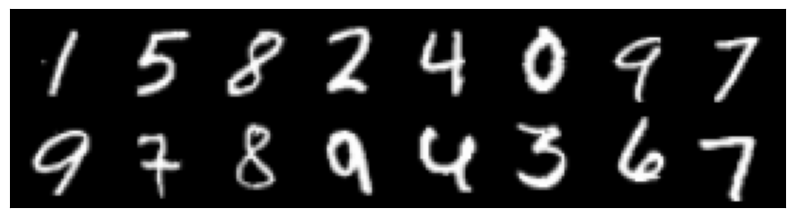

In [11]:
# visualize the batch
plot_batch(x0)

## *iii*. Variance schedules


The forward diffusion process is defined by the repeated addition of Gaussian noise to a data sample, $\mathbf{x}_{0}$, according to a pre-defined variance schedule $\beta_{1},\dots ,\beta_{T}$. We will adopt the same linear variance schedule from $\beta_{1}=10^{-4}$ to $\beta_{T}=0.02$, as defined in **section 4** of the paper.

<br>

Here, we also pre-calculate other helpful terms that derive from the variance schedule and are required for DDPM training and sampling. In particular, we compute $\alpha_{t} = 1-\beta_{t}$ and $\bar{\alpha_{t}}=\prod_{s=1}^{t} \alpha_{s}$.



In [12]:
# set maximum time value
T = 1000
### your code goes here

# define a Linear variance schedule
### your code goes here
betas = torch.linspace(1e-4, 0.02, T)

In [13]:
# pre-calculate other helpful terms that derive from the variance schedule
### your code goes here
alphas = 1 - betas
### your code goes here
alphas_cumprod = torch.cumprod(alphas, axis=0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

# define an extraction function to handle the discrepancy between batch vs schedule dimensionality
def extract(sched, t, device):
    """extract sched at time t, and expand to batch dimensionality"""

    return sched.to(device)[t.to(device)[:,None,None,None]]

## *iv*. Forward diffusion

Here, we implement the forward diffusion process (defined in **section 2**), where we take a data sample and progressively corrupt it by adding a sequence of Gaussian noise controlled by the variance schedule.

<br>

A nice property of the forward diffusion is that we can directly sample $\mathbf{x}_{t}$ at any chosen timestep $t$, without having to run through each individual step from $t=0$ to $t=t$:

<br>

$\mathbf{x}_{t} = \sqrt{\bar{\alpha}_{t}}\ \mathbf{x}_{0} + \sqrt{1-\bar{\alpha}_{t}}\ \mathbf{e}$

<br>

where $\mathbf{e} \sim \mathcal{N}(\mathbf{0},\mathbf{I})$.

In [14]:
# let's define a function that implements the forward diffusion process
def forward_diffusion(t, x0, e):### your code goes here
    """run the forward diffusion process on x up to time t using noise e"""

    ### your code goes here
    return extract(sqrt_alphas_cumprod, t, x0.device)*x0 + extract(sqrt_one_minus_alphas_cumprod, t, x0.device)*e

Let's test the forward diffusion process out on our current batch $\mathbf{x}_{0}$.

In [15]:
# sample 16 values for t that are evenly spaced from t=0 to t=T
### your code goes here
t = torch.linspace(0, T-1, len(x0), dtype=torch.long)
# draw a random sample from a normal distribution with unit variance
### your code goes here
e = torch.randn_like(x0)
# calculate the forward diffusion process for a single image from batch x0
### your code goes here
x_t = forward_diffusion(t, x0[0], e)

tensor([  0,  66, 133, 199, 266, 333, 399, 466, 532, 599, 666, 732, 799, 865,
        932, 999])


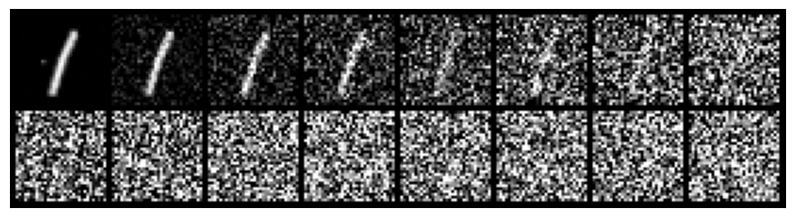

In [16]:
# display t values and visualize the forward diffusion process
print(t)
plot_batch(x_t)

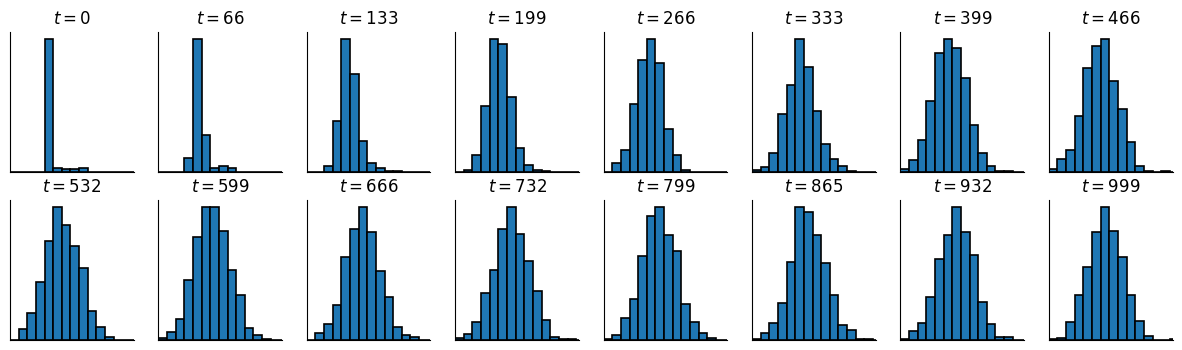

In [17]:
# display histograms of the pixel values throughout the forward diffusion
plt.figure(figsize=(15, 4))
for i in range(len(t)):
    plt.subplot(2, len(t)//2, 1+i)
    plt.hist(x_t[i].flatten(), bins=np.arange(x_t[-1].min(), x_t[-1].max() + 0.5, 0.5), edgecolor='black', linewidth=1.2)
    plt.xlim(x_t[-1].min(), x_t[-1].max())
    plt.xticks([]); plt.yticks([])
    plt.title(f'$t={t[i]}$')
    sns.despine()

## *v*. Training the model

In the training phase, shown in **algorithm 1**, we draw samples for $t$ uniformly from $1,\dots,T$ such that each image in the batch $\mathbf{x}_{0}$ has a corresponding $t$. We then apply the forward process to obtain $\mathbf{x}_{t}$.

<br>

<img src="https://drive.google.com/uc?id=1R_a69htYQa_esCHiItEobEVj9ZZAxLCN" width="800"/>

<br>

In [18]:
# line 3 of algorithm 1
### your code goes here
t = torch.randint(0, T, (x0.shape[0],), dtype=torch.long)

In [19]:
# line 4 of algorithm 1
### your code goes here
e = torch.randn_like(x0)

In [20]:
# part of line 5 of algorithm 1
### your code goes here
x_t = forward_diffusion(t, x0, e)

tensor([924, 503, 399,  35,  67, 544, 334, 745, 989, 103, 400, 180, 570,  39,
        590, 532])


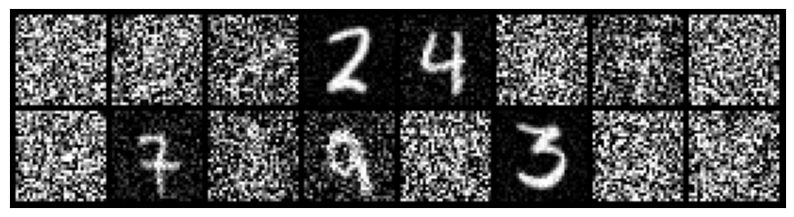

In [21]:
# display t values and visualize the forward diffusion process
print(t)
plot_batch(x_t)

At the core of the DDPM method is a denoising autoencoder, $\mathbf{e}_{\theta}(\mathbf{x}_{t}, t)$, that takes as inputs a batch of noise corrupted or forward diffused samples $\mathbf{x}_{t}=\sqrt{\bar{\alpha}_{t}}\ \mathbf{x}_{0} + \sqrt{1-\bar{\alpha}_{t}}$, and their corresponding $t$ values, and predicts the noise $\mathbf{e}$.

<br>

If such a denoising autoencoder can be trained, then it can be used to reverse the diffusion process by iteratively predicting and subtracting the noise from a random starting sample $\mathbf{x}_{T}\sim\mathcal{N}(\mathbf{0},\mathbf{I})$, effectively denoising it from time $t=T$ to $t=0$. More on this sampling approach (algorithm 2) later...

<br>

For further reading and insight about the interpretation of diffusion models as autoencoders, as well as the connections between DDPMs and SBGMs, you can check out the article below.

In [22]:
display.IFrame('https://benanne.github.io/2022/01/31/diffusion.html', width=1000, height=300)

#### **Model architecture**

A modified [U-Net](https://arxiv.org/abs/1505.04597) architecture is used for the denoising autoencoder $\mathbf{e}_{\theta}(\mathbf{x}_{t}, t)$, as mentioned in **section 4**. Crucially, the U-Net must be conditioned on time $t$, so that it is able to predict the noise $\mathbf{e}$ from a forward diffused image $\mathbf{x}_{t}$ at any time from $t=1$ to $t=T$.

<br>

As discussed in the **section 4**, this is facilitated by using sinusoidal position embeddings to represent $t$, identical to those used within the [Transformer](https://arxiv.org/abs/1706.03762) architecture. The sinusoidal position embedding takes $t$ as an input, and produces an embedding or vector that represents that particular value of $t$ (or noise level).

In [23]:
# define the sinusoidal position embeddings
class SinusoidalPositionEmbeddings(nn.Module):
    """sinusoidal position embedding, https://arxiv.org/abs/1706.03762"""

    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = np.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

This embedding is often passed through a small multi-layered perceptron (or fully connected network), and is then added to each convolutional block throughout the U-Net.

In [24]:
# define a convolutional block with time-embedding
class ConvBlock(nn.Module):
    """time-conditioned convolutional block"""

    def __init__(self, in_c, out_c, embed_dim):
        super().__init__()
        self.conv = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.dense = nn.Linear(embed_dim, out_c) # reshapes the time embedding length to the number of channels
        self.bn = nn.BatchNorm2d(out_c)
        self.act = nn.SiLU()

    def forward(self, x, t_embed):
        x = self.conv(x) ### your code goes here
        x += self.dense(t_embed)[...,None,None] ### your code goes here # add the output of the time embedding dense layer
        x = self.bn(x) ### your code goes here
        x = self.act(x) ### your code goes here
        return x

# define an encoder block of the U-Net with time-embedding
class EncBlock(nn.Module):
    """time-conditioned U-Net encoder block"""

    def __init__(self, in_c, out_c, embed_dim):
        super().__init__()
        self.conv_block1 = ConvBlock(in_c, out_c, embed_dim)
        self.conv_block2 = ConvBlock(out_c, out_c, embed_dim)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, x, t_embed):
        h = self.conv_block1(x, t_embed) ### your code goes here
        h = self.conv_block2(h, t_embed) ### your code goes here
        p = self.pool(h) ### your code goes here
        return h, p

# define an decoder block of the U-Net with time-embedding
class DecBlock(nn.Module):
    """time-conditioned U-Net decoder block"""

    def __init__(self, in_c, out_c, embed_dim):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv_block1 = ConvBlock(out_c+out_c, out_c, embed_dim)
        self.conv_block2 = ConvBlock(out_c, out_c, embed_dim)

    def forward(self, x, s, t_embed):
        h = self.up(x) ### your code goes here
        h = torch.cat([h, s], axis=1) ### your code goes here # concatenate x with U-Net skip connection from encoder
        h = self.conv_block1(h, t_embed) ### your code goes here
        h = self.conv_block2(h, t_embed) ### your code goes here
        return h

Putting it all together, we can now define our time-conditioned U-Net!

In [25]:
class Unet(nn.Module):
    """DDPM U-Net, https://arxiv.org/abs/2006.11239 and https://arxiv.org/abs/1505.04597"""

    def __init__(self, n_channels, embed_dim):
        super().__init__()

        # time positional embedding MLP
        self.embed = nn.Sequential(SinusoidalPositionEmbeddings(embed_dim),
                                   nn.Linear(embed_dim, embed_dim),
                                   nn.GELU(),
                                   nn.Linear(embed_dim, embed_dim))

        # encoder
        self.e1 = EncBlock(n_channels, 64, embed_dim)
        self.e2 = EncBlock(64, 128, embed_dim)
        self.e3 = EncBlock(128, 256, embed_dim)
        self.e4 = EncBlock(256, 512, embed_dim)

        # bottleneck
        self.b1 = ConvBlock(512, 1024, embed_dim)
        self.b2 = ConvBlock(1024, 1024, embed_dim)

        # decoder
        self.d1 = DecBlock(1024, 512, embed_dim)
        self.d2 = DecBlock(512, 256, embed_dim)
        self.d3 = DecBlock(256, 128, embed_dim)
        self.d4 = DecBlock(128, 64, embed_dim)

        # output layer
        self.output = nn.Conv2d(64, n_channels, kernel_size=1, padding=0)

    def forward(self, x, t):

        t_embed = self.embed(t)

        # encoder
        ### your code goes here
        s1, x = self.e1(x, t_embed)
        ### your code goes here
        s2, x = self.e2(x, t_embed)
        ### your code goes here
        s3, x = self.e3(x, t_embed)
        ### your code goes here
        s4, x = self.e4(x, t_embed)

        # bottleneck
        ### your code goes here
        x = self.b1(x, t_embed)
        ### your code goes here
        x = self.b2(x, t_embed)

        # decoder
        ### your code goes here
        x = self.d1(x, s4, t_embed)
        ### your code goes here
        x = self.d2(x, s3, t_embed)
        ### your code goes here
        x = self.d3(x, s2, t_embed)
        ### your code goes here
        x = self.d4(x, s1, t_embed)
        # output
        ### your code goes here
        output = self.output(x)
        ### your code goes here
        return output

#### **Algorithm 1**

The DDPM model, or denoising autoencoder, $\mathbf{e}_{\theta}(\mathbf{x}_{t}, t)$, can be trained using **algorithm 1**.

<br>

<img src="https://drive.google.com/uc?id=1R_a69htYQa_esCHiItEobEVj9ZZAxLCN" width="800"/>

<br>

In words, the training process can be stated as:

1. Randomly select a sample from the training data $\mathbf{x}_{0}$ (line 2)

2. Randomly sample $t$ from a uniform distribution over the range [1,T] (line 3)

3. Randomly sample $\mathbf{e}$ from a zero-mean normal distribution with a variance of 1 (line 4)

4. Apply the forward diffusion process on $\mathbf{x}_{0}$ using $\mathbf{e}$ and $t$ (line 5)

5. Predict the noise by evaluating $\mathbf{e}_{\theta}(\mathbf{x}_{t}, t)$ (line 5)

6. Calculate the $L_{2}$ (or MSE) loss between the true noise $\mathbf{e}$ and the predicted noise $\mathbf{e}_{\theta}(\mathbf{x}_{t}, t)$ (line 5)

7. Take a gradient descent (or Adam) step with respect to the model parameters $\theta$ (line 5)

8. Repeat steps 1 to 7 until converged (lines 1 and 6)

These steps are performed batch-wise in practice.

In [26]:
# define the model and send to the GPU
model = Unet(1, img_dim*4).to(device)

# specify the Adam optimizer with a learning rate of 2e-4 (see appendix B)
opt = torch.optim.Adam(model.parameters(), lr=2e-4)

# set the criterion to be the mse loss
criterion = F.mse_loss

In [27]:
# ensure model is in training mode
model.train()

# set number of epochs and loop over them (line 1)
n_epoch = 5
for epoch in range(n_epoch):

    # loop over each batch using tqdm to report progress and loss stats (line 1 and 2)
    pbar = tqdm(dataloader)
    for x0, _ in pbar:

        # zero the gradients
        opt.zero_grad()

        # send the batch to the GPU
        x0 = x0.to(device)

        # sample t from a uniform distribution (line 3)
        t = torch.randint(0, T, (x0.shape[0],),dtype=torch.long).to(x0.device) ### your code goes here

        # sample e from a normal distribution (line 4)
        e = torch.randn_like(x0) ### your code goes here

        # run the forward diffusion process to add noise to x0 (line 5)
        x_t = forward_diffusion(t, x0, e) ### your code goes here

        # calculate the loss between the predicted noise and the true noise (line 5)
        loss = criterion(model(x_t, t), e) ### your code goes here

        # backpropagation to obtain gradients w.r.t model parameters (line 5)
        loss.backward()

        # report current loss using tqdm
        pbar.set_description(f"loss: {loss.item():.4f}")

        # take an optimisation step
        opt.step()

loss: 0.0176: 100%|██████████| 938/938 [01:27<00:00, 10.72it/s]


In [30]:
# save the model
torch.save(model.state_dict(), 'ddpm.pt')

In [31]:
# load the model
model.load_state_dict(torch.load('ddpm.pt'))

<All keys matched successfully>

## *v*. Reverse diffusion (sampling)

Here we implement the reverse diffusion process, where we use our denoising autoencoder $\mathbf{e}_{\theta}(\mathbf{x}_{t}, t)$, to progressively undo (or denoise) a random sample from a normal distribution $\mathbf{x}_{T}$. This is achieved through **algorithm 2**.

<br>

<img src="https://drive.google.com/uc?id=1R_a69htYQa_esCHiItEobEVj9ZZAxLCN" width="800"/>

<br>

In words, the sampling process can be stated as:

1. Randomly sample $\mathbf{x}_{T}$ from a zero-mean normal distribution with a variance of 1 (line 1)

2. If $t>1$, randomly sample $\mathbf{z}$ from a zero-mean normal distribution with a variance of 1, otherwise set $\mathbf{z}=\mathbf{0}$ (line 3)

3. Calculate the updated sample $\mathbf{x}_{t-1}$ by subtracting the predicted noise $\mathbf{e}_{\theta}(\mathbf{x}_{t}, t)$ from $\mathbf{x}_{t}$ (line 4)

4. Apply $\mathbf{z}$, scaled by $\sigma_{t}$, to the sample (line 4)

5. Repeat steps 2 to 4 for $t=T,\dots,1$ (lines 2 and 5)

Scaling factors derived from the variance schedule are also used in line 4. These naturally fall out of the maths (the second term of the variational bound on the negative log likelihood), but they don't add any meaningful intuition.

<br>

We will also set $\sigma_{t} = \sqrt{\beta_{t}}$, as discussed in **section 3.2**. This means that, as $t$ approaches $0$, and **algorithm 2** converges towards the final generative sample, the variance $\beta_{t}$ will approach its minimum, and so the noise that is added in line 4 will be small.

samples at t=950


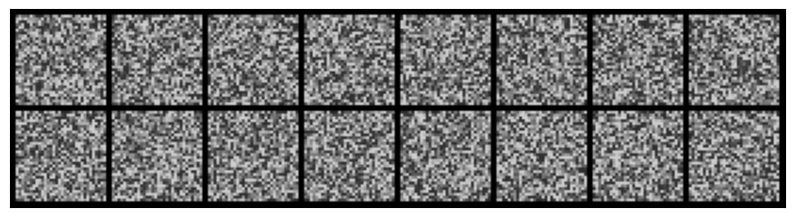

samples at t=900


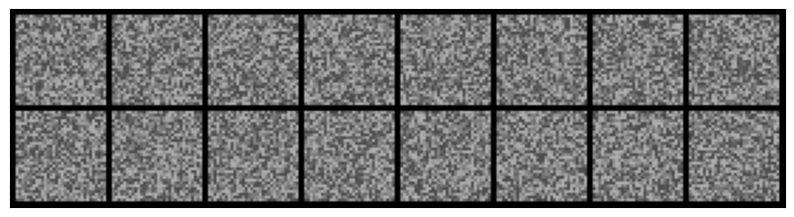

samples at t=850


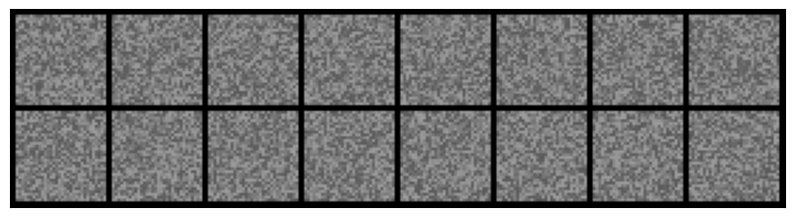

samples at t=800


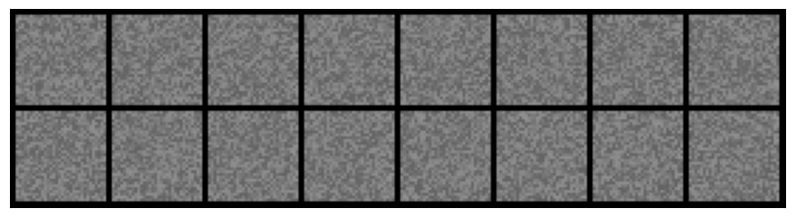

samples at t=750


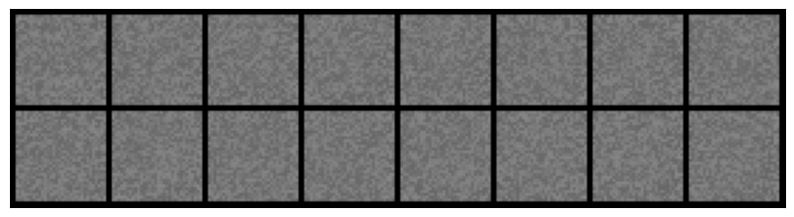

samples at t=700


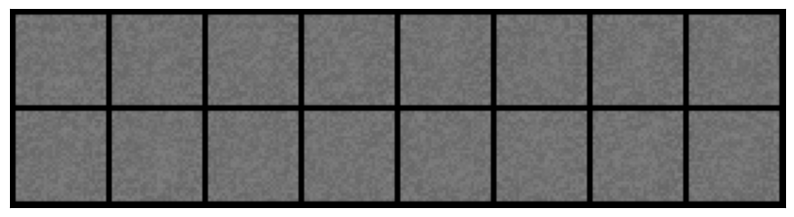

samples at t=650


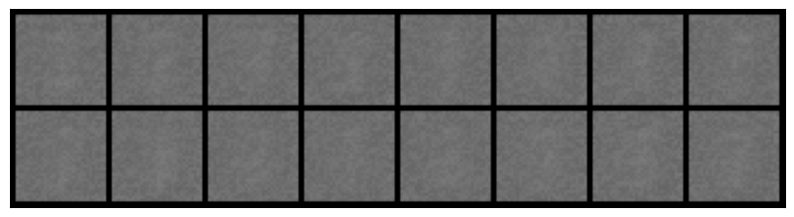

samples at t=600


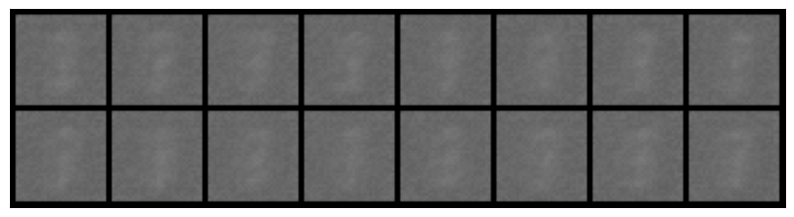

samples at t=550


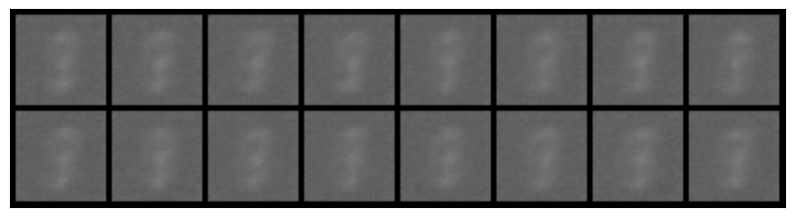

samples at t=500


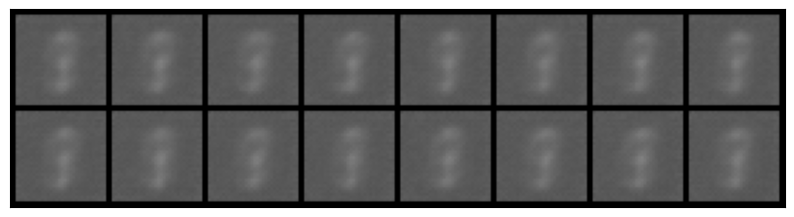

samples at t=450


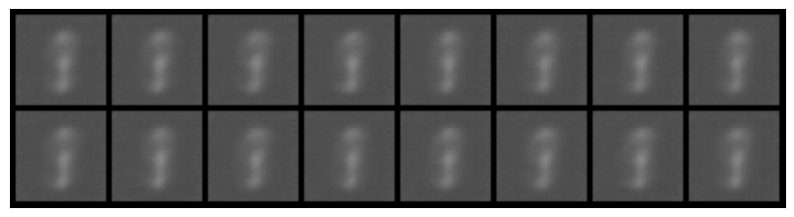

samples at t=400


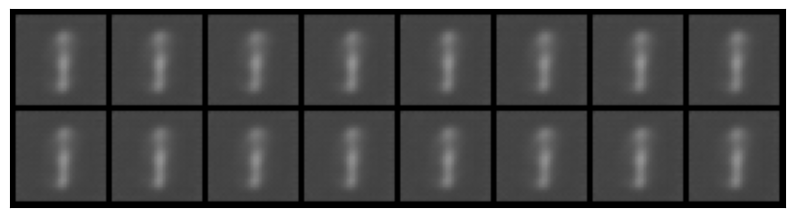

samples at t=350


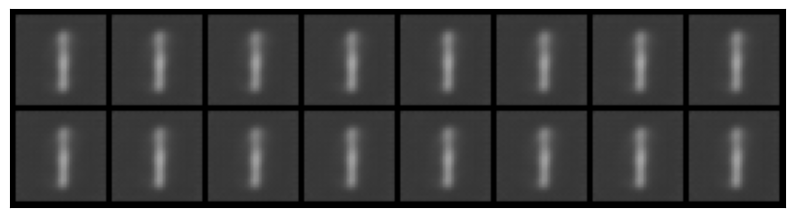

samples at t=300


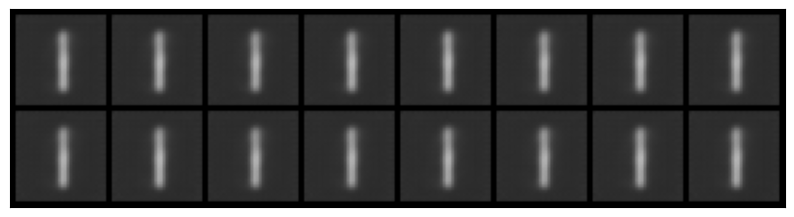

samples at t=250


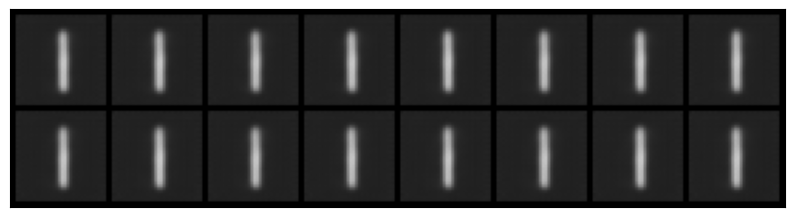

samples at t=200


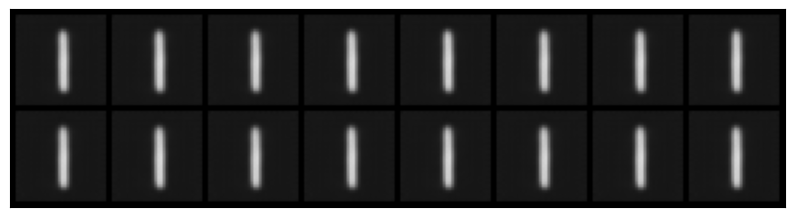

samples at t=150


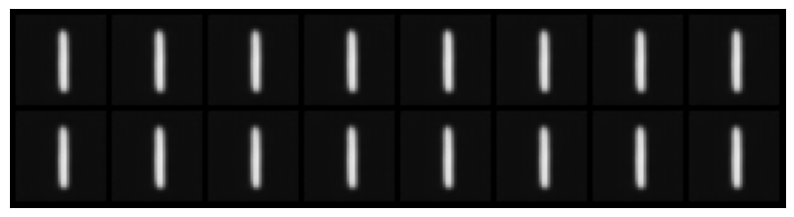

samples at t=100


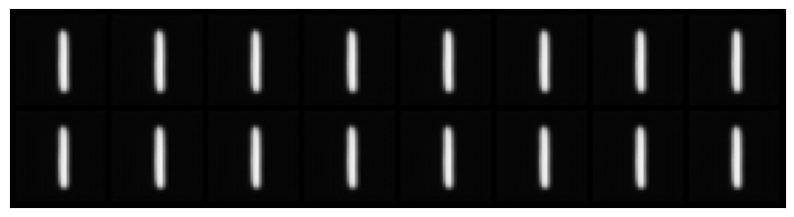

samples at t=50


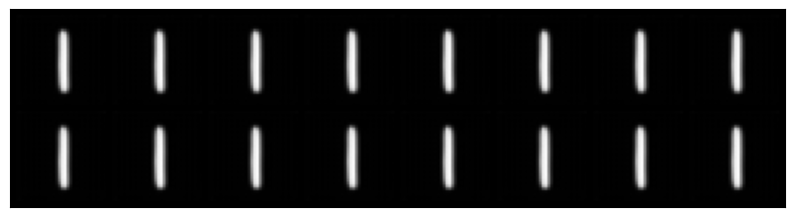

samples at t=0


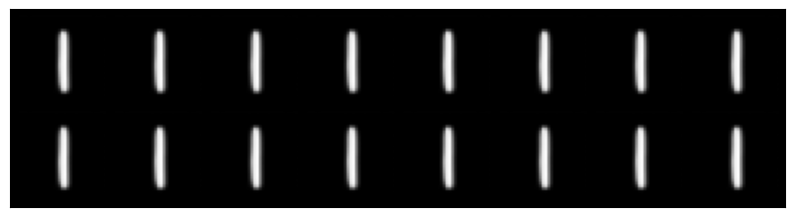

In [32]:
# ensure model is in evaluation mode
model.eval()

# randomly sample an xT batch from a normal distribution (line 1)
x = torch.randn_like(next(iter(dataloader))[0]) ### your code goes here

# send to the GPU and only consider first 16 of the batch to ease the computational burden
x = x.to(device)[:16]

# container to store sample throughout the reverse diffusion
reverse_diffusion = torch.empty((T, x.shape[0], x.shape[1], x.shape[2], x.shape[3])).to(x.device)

# context management to ensure gradients are not tracked for any torch tensors or parameters
with torch.no_grad():

    # loop over time from T to 0 (lines 2 and 5)
    ### your code goes here
    for t in reversed(range(0,T)):

        # sample z from a normal distribution if condition met (line 3)
        ### your code goes here
        if t > 0:
        ### your code goes here
            z = torch.randn_like(x)
        ### your code goes here
            z = 0
        ### your code goes here

        # visualize samples x every 100 iterations
        if t % 50 == 0:
            print(f'samples at t={t}')
            plot_batch(x.cpu())

        # convert t to a tensor, send to the GPU, and expand its first dimension to be equal to batch size
        t = torch.tensor(t).to(device).expand(x.shape[0]) ### your code goes here

        # denoise x (line 4)
        x = extract(sqrt_recip_alphas, t, x.device) * (x - ((1.-extract(alphas, t, x.device))/(extract(sqrt_one_minus_alphas_cumprod, t, x.device)))*model(x, t))### your code goes here

        # add z (line 4)
        x += torch.sqrt(extract(betas, t, x.device))*z### your code goes here

        # clipping to ensure the sample values remain in the range -1 to 1
        x = torch.clamp(x, -1, 1)

        # store the current samples x
        reverse_diffusion[t] = x

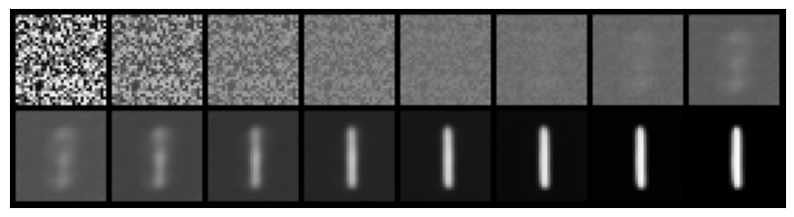

In [33]:
# visualize the diffusion process for a single sample
plot_batch(reverse_diffusion[::66,0].flip(0).cpu())

Congratulations, you have implemented and trained a DDPM diffusion model!